# Example usage

To use `torch_mist` in a project:

In [1]:
import torch
from torch.distributions import MultivariateNormal

In [2]:
import torch_mist

print(torch_mist.__version__)

0.1.0


## Data loading

We first define a simple dataset that returns pairs of samples from a bivariate normal distribution.

In [3]:

rho = 0.9
cov = torch.tensor([[1, rho], [rho, 1.]])
mean = torch.tensor([0., 0.])
x_dim = y_dim = n_dim = 1

p_xy = MultivariateNormal(
    mean.unsqueeze(0).repeat(n_dim,1),
    cov.unsqueeze(0).repeat(n_dim,1,1))


print(p_xy)

MultivariateNormal(loc: torch.Size([1, 2]), covariance_matrix: torch.Size([1, 2, 2]))


Visualization of the samples

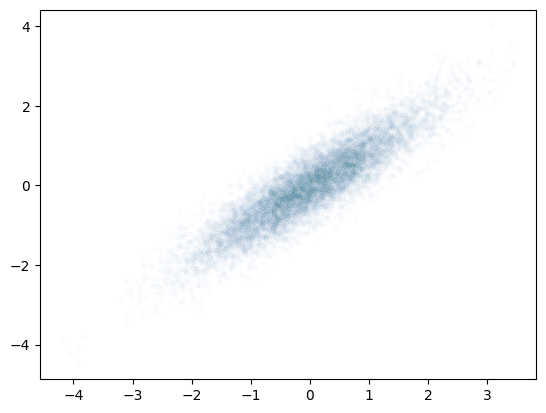

In [4]:
import matplotlib.pyplot as plt

samples = p_xy.sample([10000])

plt.scatter(
    samples.reshape(-1,2)[:,0],
    samples.reshape(-1,2)[:, 1],
    marker='.',
    alpha=0.01
)


We can compute the true mutual information as a reference

In [5]:
true_mi = (
        MultivariateNormal(mean, torch.eye(2)).entropy() - p_xy.entropy()
).sum()
print('True Mutual Information:', true_mi.item(), 'nats')

True Mutual Information: 0.8303654193878174 nats


We then wrap the distribution into a torch DataLoader

In [6]:
from torch_mist.utils.data import SampleDataLoader

trainloader = SampleDataLoader(
    p_xy,
    batch_size=64,
    max_samples=100000 # Number of samples per epoch
)

testloader = SampleDataLoader(
    p_xy,
    batch_size=64,
    max_samples=10000,
)


# This dataloader simply returns pairs of samples from p(x,y)
# with shape [batch_size, X_DIM] [batch_size, Y_DIM]
for x, y in trainloader:
    break

print(x.shape, y.shape)

torch.Size([64, 1]) torch.Size([64, 1])


## Estimator definition

We define a simple mutual information estimator based on Deep-InfoMax (JS)

In [7]:
from torch_mist.estimators import JS
from torch_mist.critic import JointCritic
from torch import nn

# First we define a critic network that maps pairs of samples to a scalar
critic = JointCritic(
    joint_net=nn.Sequential(
        nn.Linear(x_dim + y_dim, 64),
        nn.ReLU(True),
        nn.Linear(64, 64),
        nn.ReLU(True),
        nn.Linear(64, 1),
    )
)

# We also specify the number of Monte Carlo samples to use for the estimation of the normalization constant
mc_samples = 16

# Then we pass it to the Jensen-Shannon estimator
mi_estimator = JS(
    critic=critic,
    mc_samples=mc_samples
)

print(mi_estimator)

JS(
  (critic): JointCritic(
    (joint_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (mc_samples): 16
)


## Training
We now define an optimizer and train the estimator

In [8]:
from tqdm.auto import tqdm
from torch.optim import AdamW

# Use the AdamW optimizer with a learning rate of 5e-4
opt = AdamW(mi_estimator.parameters(), lr=5e-4)

# Train for 3 epochs
n_epochs = 3

# Create an empty log to visualize the training progress
log = []

# For each epoch
for epoch in range(n_epochs):
    for x, y in tqdm(trainloader):
        # Compute the mutual information
        mi = mi_estimator(x, y)
        # And the corresponding loss
        loss = mi_estimator.loss(x, y)

        # Reset the gradients
        opt.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        opt.step()

        # Log the loss
        log.append({
            'iteration': len(log),
            'loss': loss.item(),
            'mi': mi.item()
        })


  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

## Visualization
We can plot loss and estimated mutual information over time

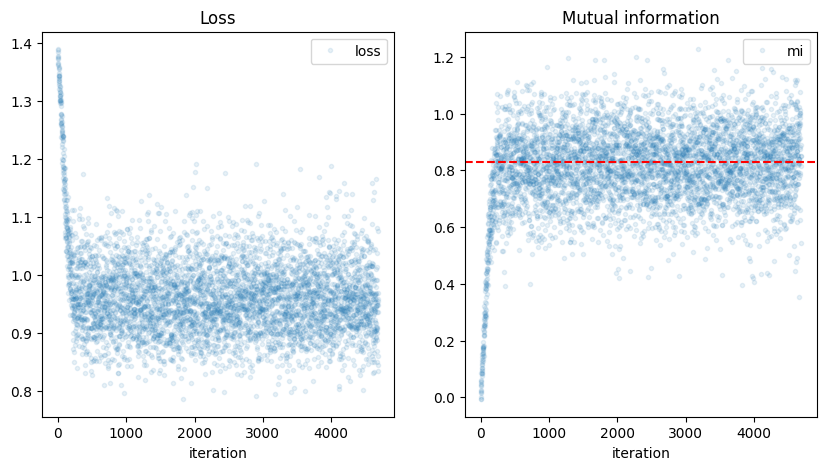

In [9]:
import pandas as pd

f, ax = plt.subplots(1, 2, figsize=(10, 5))
pd.DataFrame(log).plot(x='iteration', y='loss', ax=ax[0], marker='.', ls='', alpha=0.1)
pd.DataFrame(log).plot(x='iteration', y='mi', ax=ax[1], marker='.', ls='', alpha=0.1)

ax[0].set_title('Loss')
ax[1].set_title('Mutual information')

ax[1].axhline(true_mi.item(), color='red', ls='--')

## Evaluation
We can now evaluate the estimator on the test set

In [10]:
import numpy as np

mi_estimates = []
for x, y in tqdm(testloader):
    mi_estimates.append(mi_estimator(x, y).item())

# Print mean and std of the estimates
print('Estimate: {:.3f} +- {:.3f}'.format(
    np.mean(mi_estimates),
    np.std(mi_estimates)
))

print('True: {:.3f}'.format(true_mi.item()))


  0%|          | 0/156 [00:00<?, ?it/s]

Estimate: 0.833 +- 0.119
True: 0.830


## Utilities and shortcuts

The library includes utilities to avoid explicitly defining the critic network and the optimization loop

In [11]:
from torch_mist.estimators import js

mi_estimator = js(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
    mc_samples=mc_samples
)

mi_estimator

JS(
  (critic): JointCritic(
    (joint_net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): Linear(in_features=64, out_features=64, bias=True)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
      (f): ReLU(inplace=True)
    )
  )
  (mc_samples): 16
)

In [12]:
from torch_mist.utils import optimize_mi_estimator

# Train the estimator for 5 epochs
log = optimize_mi_estimator(
    estimator=mi_estimator,
    dataloader=trainloader,
    n_epochs=n_epochs,
    optimizer_class=AdamW,
    optimizer_params={
        'lr': 5e-4
    }
)


  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

In [13]:
from torch_mist.utils import estimate_mi

mi_value, mi_std = estimate_mi(
    estimator=mi_estimator,
    dataloader=testloader
)

print('Estimate: {:.3f} +- {:.3f}'.format(
    mi_value,
    mi_std
))

print('True: {:.3f}'.format(true_mi.item()))

Estimate: 0.824 +- 0.136
True: 0.830
